Reference: https://www.kaggle.com/utcarshagrawal/ubiquant-exploration-baseline-w-shap/notebook

In [1]:
# matplotlib cyberpunk style

!pip -q --disable-pip-version-check install mplcyberpunk

# Importing Libraries

In [2]:
import os
import gc
import numpy as np
import pandas as pd

# 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import mplcyberpunk
plt.style.use('cyberpunk')

import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [3]:
%%time
df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

CPU times: user 6.32 s, sys: 8.41 s, total: 14.7 s
Wall time: 39.5 s


### parquet vs csv
- parquet이란?
>하둡에서 컬럼방식으로 저장한 포맷
- 장점
> 저장 크기가 작다.  
> 저장, 로드 시간 작다.  
> 칼럼별 dtype을 다시 지정해줄 필요 X  
- parquet >> csv
- Q.그럼 pickle과는??

In [4]:
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


# EDA

### Investment_id Distribution
> First of all we will look at the count of samples in each investment id

Number of unique investments - 3579
Investment id with least number of sample - 1415, Count - 2
Investment id with maximum number of sample - 2140, Count - 1211


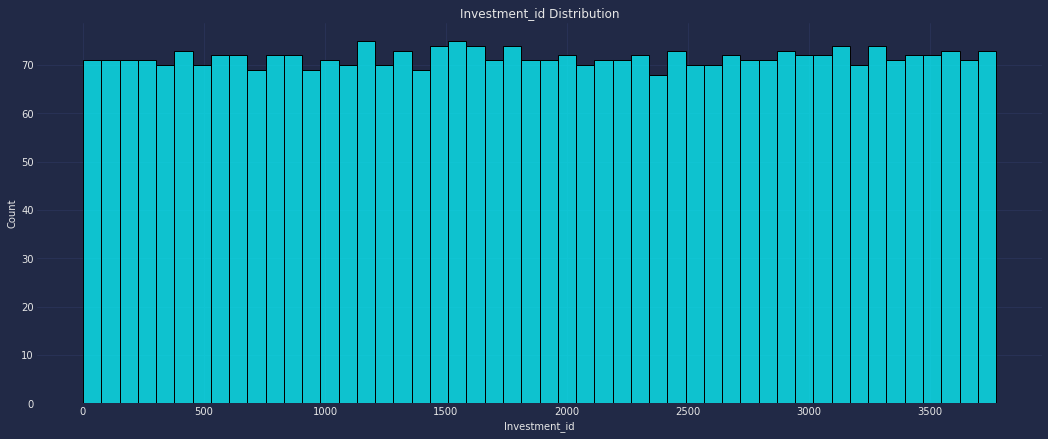

In [6]:
# 단순 investment 분포 정도를 그래프로 본다.

plt.figure(figsize = (18, 7))

# investment_id count df
df_temp = df.groupby('investment_id')['row_id'].count().reset_index()
sns.histplot(x = df_temp['investment_id'], bins = 50)
plt.xlabel('Investment_id')
plt.ylabel('Count')
plt.title('Investment_id Distribution')

least_id = int(df_temp[df_temp['row_id'] == df_temp['row_id'].describe()['min']]['investment_id'])
max_id = int(df_temp[df_temp['row_id'] == df_temp['row_id'].describe()['max']]['investment_id'])

print(f"Number of unique investments - {len(df_temp)}")
print(f"Investment id with least number of sample - {least_id}, Count - {int(df_temp['row_id'].describe()['min'])}")
print(f"Investment id with maximum number of sample - {max_id}, Count - {int(df_temp['row_id'].describe()['max'])}")

plt.show()

In [7]:
df_temp.head()

,investment_id,row_id
0,0,461
1,1,1108
2,2,1003
3,3,1076
4,4,316


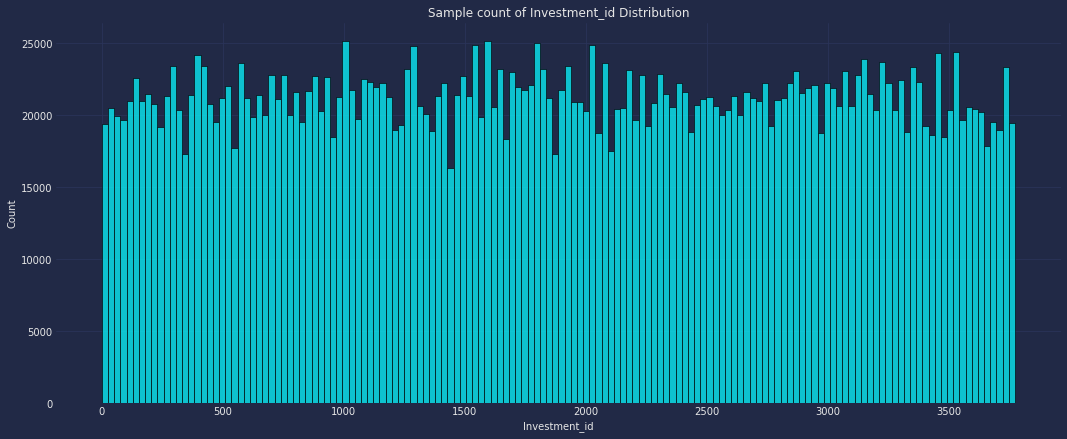

In [8]:
# investment id의 count 분포를 histogram으로 표현
# 개별 count는 df_temp로 기록함
# histogram으로 개별 count 경향 보다는 뭉쳐서 나타낸다.

plt.figure(figsize = (18, 7))
sns.histplot(x = df['investment_id'])
plt.xlabel('Investment_id')
plt.ylabel('Count')
plt.title('Sample count of Investment_id Distribution')
plt.show()

- print 에서 따옴표는 조심해야 한다. 작은 따옴표(') 대신 큰 따옴표(") 사용을 습관화하자

### Time_id Distribution
> Now let us look at the count of samples in each time id

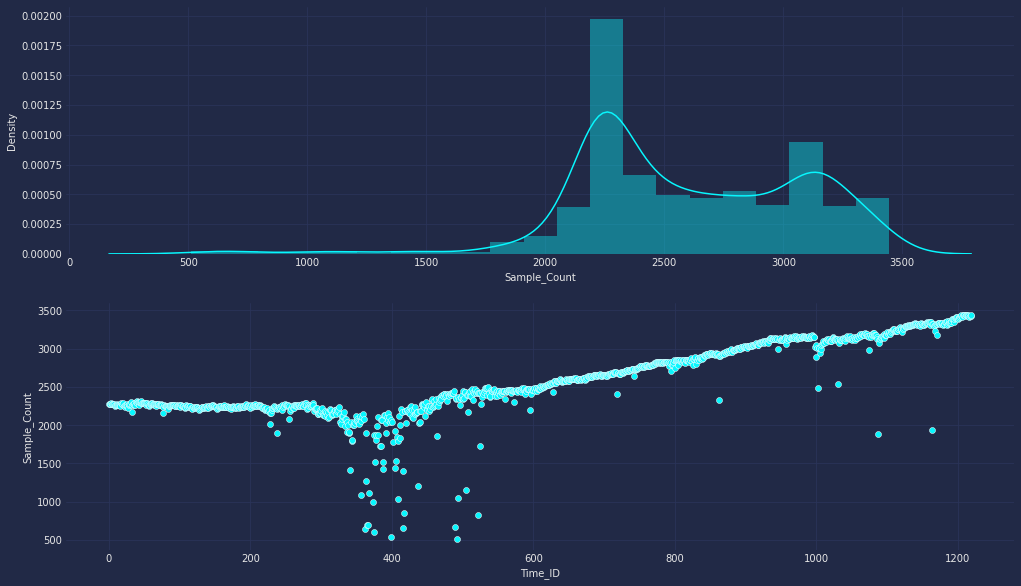

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (17, 10))

df_temp = df.iloc[:, 0:3]
df_temp2 = df_temp.groupby('time_id')['investment_id'].count().reset_index().rename(columns = {'investment_id' : 'Sample_Count'})

sns.distplot(x = df_temp2['Sample_Count'], ax = ax[0])
sns.scatterplot(x = df_temp2['time_id'], y = df_temp2['Sample_Count'], ax = ax[1])

ax[0].set_xlabel('Sample_Count')
ax[1].set_xlabel('Time_ID')

plt.show()

In [10]:
least_id = int(df_temp2[df_temp2['Sample_Count'] == df_temp2['Sample_Count'].describe()['min']]['time_id'])
max_id = int(df_temp2[df_temp2['Sample_Count'] == df_temp2['Sample_Count'].describe()['max']]['time_id'])

print(f"Number of unique time_ids - {len(df_temp2)}")
print(f"Time_id with least number of samples - {least_id}, Count - {int(df_temp2['Sample_Count'].describe()['min'])}")
print(f"Time_id with maximum number of samples - {max_id}, Count - {int(df_temp2['Sample_Count'].describe()['max'])}")

Number of unique time_ids - 1211
Time_id with least number of samples - 492, Count - 512
Time_id with maximum number of samples - 1214, Count - 3445


### Target Distribution
> Then let's analysis the target distribution

Mean of target - -0.021091585978865623
Minimum value of target - -9.419646263122559
Maximum value of target - 12.038613319396973


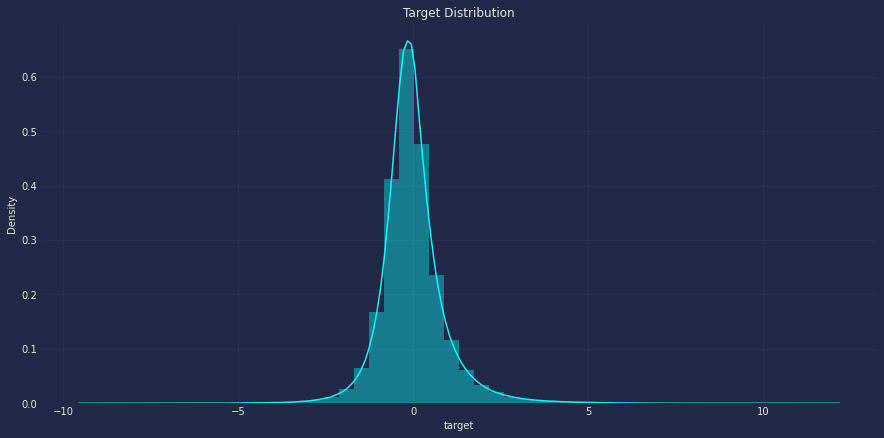

In [11]:
plt.figure(figsize = (15, 7))

sns.distplot(df['target'])
plt.title('Target Distribution')

print(f"Mean of target - {df['target'].describe()['mean']}")
print(f"Minimum value of target - {df['target'].describe()['min']}")
print(f"Maximum value of target - {df['target'].describe()['max']}")

> The `target` is normally distribution with mean of -0.0210... Let us also look the most skewed `target` distribution categorized by `investment_id` ans `time_id` respectively

Investment_IDs with most skewed target are - 1495, 2800
Time_IDs with most skewed target are - 401, 951


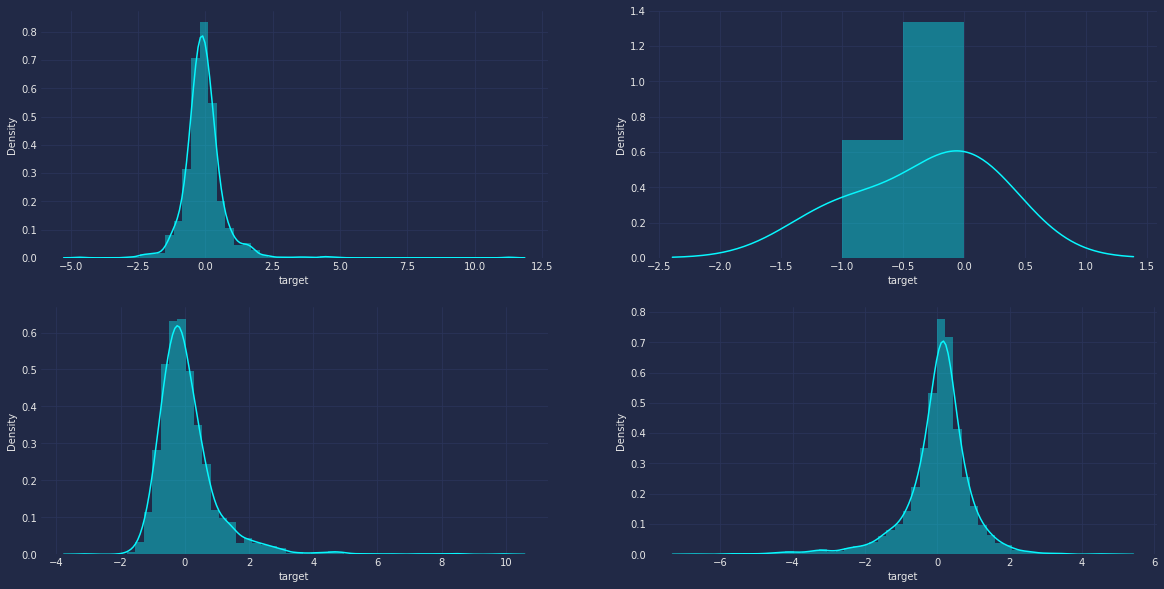

In [12]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

df_temp = df.iloc[:, 0:4]
df_temp1 = df_temp.groupby('investment_id').skew()['target'].reset_index()
id_1 = int(df_temp1[df_temp1['target'] == df_temp1['target'].describe()['max']]['investment_id'])
id_2 = int(df_temp1[df_temp1['target'] == df_temp1['target'].describe()['min']]['investment_id'])

select_1 = df_temp[df_temp['investment_id'] == id_1][['target']]
select_2 = df_temp[df_temp['investment_id'] == id_2][['target']]
sns.distplot(select_1['target'], ax = ax[0, 0])
sns.distplot(select_2['target'], ax = ax[0, 1])
print(f"Investment_IDs with most skewed target are - {id_1}, {id_2}")

df_temp2 = df_temp.groupby('time_id').skew()['target'].reset_index()
id_3 = int(df_temp2[df_temp2['target'] == df_temp2['target'].describe()['max']]['time_id'])
id_4 = int(df_temp2[df_temp2['target'] == df_temp2['target'].describe()['min']]['time_id'])

select_3 = df_temp[df_temp['time_id'] == id_3][['target']]
select_4 = df_temp[df_temp['time_id'] == id_4][['target']]
sns.distplot(select_3['target'], ax = ax[1, 0])
sns.distplot(select_4['target'], ax = ax[1, 1])
print(f"Time_IDs with most skewed target are - {id_3}, {id_4}")

plt.show()

### Time_id Categorized
> I decided to group `time_id` into 5 different categories according to their range, i.e. {(~, 250), (251, 500), (501, 750), (751, 1000), (1000, ~)} to know better about data with time. We will check different things like how many sample counts, missing values per category are there, target distribution across each `time_id` range and later on feature distribution.